In [1]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, box
from matplotlib.patches import FancyBboxPatch, BoxStyle
#import re
from matplotlib.path import Path

read_smaller_states = True

# #these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {
    'GA': {},
    'NC': {},
            }

g = 0
scale = 20
map_buffer_ratio = .1
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "

equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
absolute_overlap_tol = 100    # tolerance for declaring areas overlapping, in sq meters
desired_pct_area_overlap = 0.5     # relative overlap to declare something a match

show_water = True
show_roads = False



water_area_tol = .5 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
#district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'purple', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [3]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [4]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [5]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [6]:
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
#state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('STATE_NAME')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('STATE').sort_index()

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

for this_state in these_states_dict.keys():
    these_states_dict[this_state]['STATEFP'] = state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]    
    these_states_dict[this_state]['seats_old'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_old'].values[0]
    these_states_dict[this_state]['seats_new'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_new'].values[0]
#pprint(these_states_dict)
print('\n')
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))



looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!


Got old and new numbers of districts for 2 focus states in 0.0 seconds!


# Read summary levels

In [7]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.1 seconds!


# Read redistricting geo data

In [8]:
s = time.time()
print('reading redistricting geography data for all states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

# geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
# geo_df.set_index('SUMLEV')
# print('adding summary level descriptions...')
# geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
# geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for all states...
	reading gageo2020.pl...
	reading ncgeo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 675,486 geographies in 0 minutes 31 seconds!


In [9]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.1 seconds!


In [10]:
s = time.time()
print('Getting current Congressional District data...')
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


Getting current Congressional District data...
adding shapefiles...


Joined 27 congressional districts to shapefiles in 4.7 seconds!


In [11]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state))
    #print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')


#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for GA...
	getting shapefiles for NC...


Joined 5,468 tracts to shapefiles in 12.8 seconds!


In [12]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [13]:
s = time.time()
this_state = 'NC'

state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
#state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'COUNTYNS'] = pandas.to_numeric(county_gdf['COUNTYNS'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
#county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()

    for i in range(0, len(waterfiles)):
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf.loc[:, 'MEMI'] = pandas.to_numeric(cbsa_gdf['MEMI'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

print('\tFinding populations of CBSAs...')
cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
for ix, thisrow in cbsa_gdf.sort_values(by='NAME').iterrows():
    cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
    if (this_state in thisrow['NAME']):
        print('\t\t{0:} (n = {1:,.0f})...'.format(thisrow['NAME'], cbsa_gdf.loc[ix]['POP100']))
cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(place_gdf['STATEFP'])
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,1) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')


cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x)][['NAME', 'POP100']].sort_values(by='POP100', ascending=False)


getting states...
getting counties...
Got 56 states and 3,234 counties in 6.5 seconds!


getting water areas...
	reading water file 0 of 259...
	reading water file 10 of 259...
	reading water file 20 of 259...
	reading water file 30 of 259...
	reading water file 40 of 259...
	reading water file 50 of 259...
	reading water file 60 of 259...
	reading water file 70 of 259...
	reading water file 80 of 259...
	reading water file 90 of 259...
	reading water file 100 of 259...
	reading water file 110 of 259...
	reading water file 120 of 259...
	reading water file 130 of 259...
	reading water file 140 of 259...
	reading water file 150 of 259...
	reading water file 160 of 259...
	reading water file 170 of 259...
	reading water file 180 of 259...
	reading water file 190 of 259...
	reading water file 200 of 259...
	reading water file 210 of 259...
	reading water file 220 of 259...
	reading water file 230 of 259...
	reading water file 240 of 259...
	reading water file 250 of 259...
Got 1,347 water

,NAME,POP100
GEOID,,
16740,"Charlotte-Concord-Gastonia, NC-SC",2249929.0
39580,"Raleigh-Cary, NC",1413982.0
24660,"Greensboro-High Point, NC",776566.0
49180,"Winston-Salem, NC",675966.0
20500,"Durham-Chapel Hill, NC",649903.0
22180,"Fayetteville, NC",520378.0
11700,"Asheville, NC",469015.0
25860,"Hickory-Lenoir-Morganton, NC",365276.0
48900,"Wilmington, NC",285905.0


In [14]:

# s = time.time()
# print('setting up insets...')
# insets = {}

# insets['se'] = {}
# insets['se']['how'] = 'districts'
# insets['se']['bounds'] = [-80.48, 25.54, -80, 26.84]
# insets['se']['axes_position'] = [0.3, 0.01]
# insets['se']['axes_rel_size'] = .255
# insets['se']['districts'] = [21,22,23,24,27]
# insets['se']['partial_districts'] = [18,20,25,26]
# insets['se']['counties'] = ['Palm Beach County', 'Broward County', 'Miami-Dade County']
# insets['se']['title'] = 'Southeast Florida'
# insets['se']['titlesize'] = 22
# insets['se']['borderwidth'] = 3

# insets['tpa'] = {}
# insets['tpa']['how'] = 'districts'
# #insets['tpa']['bounds'] = [-82.85, 27.6, -82, 28.2]
# insets['tpa']['bounds'] = [-82.9, 27.6, -82.18, 28.2]
# insets['tpa']['axes_position'] = [0.03, 0.015]
# insets['tpa']['axes_rel_size'] = 0.255
# insets['tpa']['districts'] = [13,14]
# insets['tpa']['partial_districts'] = [12, 15, 16]
# insets['tpa']['counties'] = ['Hillsborough County', 'Pinellas County']
# insets['tpa']['title'] = 'Tampa Bay'
# insets['tpa']['titlesize'] = 22
# insets['tpa']['borderwidth'] = 3

# insets['orl'] = {}
# insets['orl']['how'] = 'counties'
# insets['orl']['bounds'] = [-81.68, 28.33, -80.82, 28.88]

# insets['orl']['axes_position'] = [0.03, 0.26]
# insets['orl']['axes_rel_size'] = 0.255
# insets['orl']['districts'] = [7,10]
# insets['orl']['partial_districts'] = [6,8,9,11,15]
# insets['orl']['counties'] = ['Orange County', 'Seminole County']
# insets['orl']['title'] = 'Orlando'
# insets['orl']['titlesize'] = 22
# insets['orl']['borderwidth'] = 3

# insets['jax'] = {}
# insets['jax']['how'] = 'counties'
# insets['jax']['axes_position'] = [0.84, 0.87]
# insets['jax']['axes_rel_size'] = 0.15
# insets['jax']['districts'] = [4,5]
# insets['jax']['partial_districts'] = [3]
# insets['jax']['counties'] = ['Duval County']
# insets['jax']['title'] = 'Jacksonville'
# insets['jax']['titlesize'] = 22
# insets['jax']['borderwidth'] = 3

# insets['tally'] = {}
# insets['tally']['how'] = 'places'
# insets['tally']['axes_position'] = [0.84, 0.69]
# insets['tally']['axes_rel_size'] = 0.15
# insets['tally']['districts'] = [2,5]
# insets['tally']['partial_districts'] = []
# insets['tally']['counties'] = ['Leon County']
# insets['tally']['places'] = ['Tallahassee']
# insets['tally']['title'] = 'Tallahassee'
# insets['tally']['titlesize'] = 22
# insets['tally']['borderwidth'] = 3


# for inset_name, inset in insets.items():
#     print(inset_name)
    
#     if ('bounds' in inset.keys()):
#         inset['aspect_ratio'] = (inset['bounds'][2] - inset['bounds'][0]) / (inset['bounds'][3] - inset['bounds'][1])
#     else:
#         if (inset['how'] == 'districts'):
#             thegeo = unary_union(cd_gdf[cd_gdf['CD116'].isin(inset['districts'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'counties'):
#             thegeo = unary_union(tract_gdf[tract_gdf['COUNTY_NAME'].isin(inset['counties'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'places'):
#             thegeo = unary_union(place_gdf[place_gdf['NAME'].isin(inset['places'])].geometry.tolist()).bounds
#         xlims = [thegeo[0], thegeo[2]]
#         ylims = [thegeo[1], thegeo[3]]        
#         xspan = xlims[1] - xlims[0]
#         yspan = ylims[1] - ylims[0]
#         inset['aspect_ratio'] = xspan / yspan
#         xlims[0] = xlims[0] - (map_buffer_ratio * xspan)
#         ylims[0] = ylims[0] - (map_buffer_ratio * yspan)
#         xlims[1] = xlims[1] + (map_buffer_ratio * xspan)
#         ylims[1] = ylims[1] + (map_buffer_ratio * yspan)    
#         inset['bounds'] = [xlims[0], ylims[0], xlims[1], ylims[1]]
#         print(inset['bounds'])
    
#     inset['box_gdf'] = geopandas.GeoDataFrame(data=[[
#         box(
#             inset['bounds'][0], 
#             inset['bounds'][1], 
#             inset['bounds'][2], 
#             inset['bounds'][3]
#         )]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')    
#     inset['axes_size'] = [inset['axes_rel_size'], inset['axes_rel_size'] / inset['aspect_ratio']]
# #    print(inset['axes_size'])

# all_inset_districts = []
# for inset in insets.values():
#     all_inset_districts += inset['districts']
# main_map_districts = [x for x in list(range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1)) if x not in all_inset_districts]

# main_map_districts += [x for x in insets['jax']['districts']]
# main_map_districts += [x for x in insets['tally']['districts']]
# main_map_districts = sorted(main_map_districts)

# #print(main_map_districts)
# e = time.time()
# g += (e-s)
# print('Done!')
# #main_map_districts


main map...
	reprojecting...
	plotting...
		Plotting NC...
		Plotting GA...
	plotting census tracts...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...
Done plotting in 37 seconds!


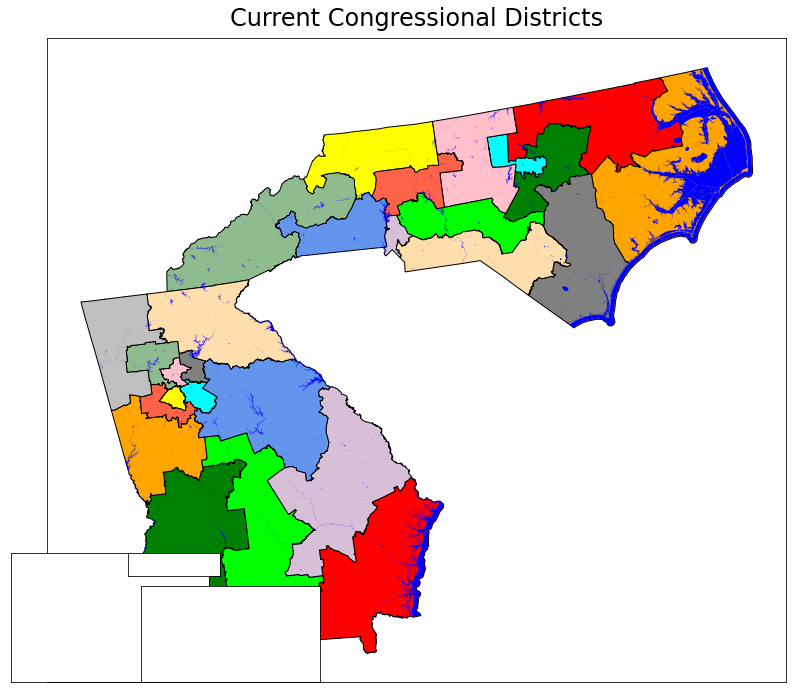

In [15]:
s = time.time()
# main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
# alaska_crs = "epsg:3338"
# hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = True

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].tolist():#.sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    cdlist = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(cdlist)+1):
        cd_gdf[
            (cd_gdf['STUSAB'] == this_state) 
            & (cd_gdf['CD116'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
#         annotator = i
#         this_district_geo = unary_union(cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == i)].to_crs(main_map_crs).geometry.tolist())
#         centerpoint = (this_district_geo.centroid.x, this_district_geo.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
# #ax.legend(handles=legend_list, fontsize=10)


if (len(list(these_states_dict.keys())) == 1):
    ax.set_title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
    ), fontsize=24, y=1.01)
else:
    ax.set_title('Current Congressional Districts', fontsize=24, y=1.01)

# # # # ax.tick_params(axis='both', labelsize=20)

# # # # # print('saving figure...')
# # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # #plt.show()
# # e = time.time()
# # g += (e-s)
# # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'AK']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'HI']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'HI') & (cd_gdf['CD116'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

for thisax in [ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

# print('saving figure...')
# fig.savefig(script_dir+'all-districts-orig.jpg', format='jpg', dpi=300, bbox_inches='tight')
#plt.show()
e = time.time()
g += (e-s)
print('Done plotting in {0:,.0f} seconds!'.format(e-s))

# How many districts in each state?

In [16]:
for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        these_states_dict[this_state_name]['target'] = -1
    else:
        these_states_dict[this_state_name]['target'] = cd_gdf[cd_gdf['STUSAB'] == this_state_name]['POP100'].sum() / this_state['seats_new']
    
    
these_states_dict
#water_gdf.head(1).T

{'GA': {'STATEFP': 13,
  'seats_old': 14,
  'seats_new': 14,
  'target': 765136.2857142857},
 'NC': {'STATEFP': 37,
  'seats_old': 13,
  'seats_new': 14,
  'target': 745670.5714285715}}

# GEORGIA

In [17]:
s = time.time()

this_state = 'GA'
examine_duplicates = True

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

#print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[ 
['Douglas County',11],


['Clayton County',13],
    ['Rockdale County',13],
    ['Fayette County',13],


['Richmond County',12],
    ['Columbia County',12],
    ['Burke County',12],
    ['McDuffie County',12],
    ['Warren County',12],
    ['Jefferson County',12],
    ['Jenkins County',12],
    ['Screven County',12],
    ['Glascock County',12],
    ['Bulloch County',12], 
    ['Evans County',12], 
    ['Tattnall County',12], 
    ['Candler County',12], 
    ['Emanuel County',12], 
    ['Treutlen County',12], 
    ['Washington County',12], 
    ['Johnson County',12], 
    ['Toombs County',12],
    ['Montgomery County',12],
    ['Appling County',12],
    ['Bacon County',12],
    ['Jeff Davis County',12],
    ['Wheeler County',12], 
    
    
['Chatham County',1],
    ['Liberty County',1], 
    ['McIntosh County',1], 
    ['Glynn County',1], 
    ['Camden County',1], 
    ['Long County',1], 
    ['Wayne County',1], 
    ['Brantley County',1], 
    ['Charlton County',1],
    ['Ware County',1],
    ['Clinch County',1],
    ['Echols County',1],
    ['Lanier County',1],
    ['Pierce County',1],

    
['Bibb County',8], 
    ['Jones County',8], 
    ['Twiggs County',8],
    ['Baldwin County',8], 
    ['Putnam County',8], 
    ['Wilkinson County',8], 
    ['Butts County',8], 
    ['Jasper County',8], 
    ['Newton County',8], 
    ['Peach County',8], 
    ['Houston County',8], 
    ['Bleckley County',8], 
    ['Hancock County',8], 
    ['Monroe County',8], 
    ['Crawford County',8], 
    ['Macon County',8], 
    ['Pulaski County',8],
    

    
['Sumter County',2], 
    ['Dooly County',2], 
    ['Wilcox County',2], 
    ['Crisp County',2], 
    ['Ben Hill County',2], 
    ['Coffee County',2],
    ['Quitman County',2], 
    ['Clay County',2], 
    ['Randolph County',2], 
    ['Terrell County',2], 
    ['Lee County',2], 
    ['Calhoun County',2], 
    ['Tift County',2], 
    ['Werner County',2], 
    ['Irwin County',2], 
    ['Worth County',2],
    ['Atkinson County',2], 
    ['Berrien County',2],
    ['Turner County',2], 
    ['Dougherty County',2], 
    ['Early County',2], 
    ['Miller County',2], 
    ['Baker County',2], 
    ['Mitchell County',2], 
    ['Colquitt County',2], 
    ['Cook County',2], 
    ['Brooks County',2],  
    ['Thomas County',2],  
    ['Grady County',2],  
    ['Decatur County',2],  
    ['Seminole County',2], 
    ['Dodge County',2],
    ['Telfair County',2], 
    ['Schley County',2], 


    
['Chattahoochee County',3],
    ['Harris County',3],
    ['Marion County',3],
    ['Muscogee County',3],
    ['Russell County',3],
    ['Stewart County',3],
    ['Talbot County',3],
    ['Taylor County',3],
    ['Webster County',3],
    ['Upson County',3],
    ['Pike County',3],
    ['Lamar County',3],
    ['Spalding County',3],
    ['Meriwether County',3], 
    ['Troup County',3], 
    ['Coweta County',3], 
    ['Heard County',3],


    
['Clarke County',10],
    ['Madison County',10],
    ['Oconee County',10],
    ['Oglethorpe County',10],
    ['Greene County',10], 
    ['Morgan County',10], 
    ['Walton County',10], 
    ['Lincoln County',10], 
    ['Wilkes County',10], 
    ['Elbert County',10], 
    ['Barrow County',10], 
    ['Jackson County',10],
    ['Taliaferro County',10],
    ['Hart County',10],



['Hall County',9],
    ['Franklin County',9],
    ['Stephens County',9],
    ['Banks County',9], 
    ['Habersham County',9], 
    ['Rabun County',9], 
    ['Towns County',9], 
    ['White County',9], 
    ['Union County',9], 
    ['Lumpkin County',9], 
    ['Dawson County',9],
    ['Fannin County',9],
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Atlanta',5],
    ['Sandy Springs',5],
    ['Roswell',5],
    ['Alpharetta',5],
    ['Druid Hills',5],


['Milton',6],
    ['Marietta',6], 
    ['Kennesaw',6], 
    ['Kennesaw State University',6],
    ['Fair Oaks',6],
    ['Acworth',6],
    ['Woodstock',6],
    ['Holly Springs',6],
    

['Johns Creek',4],
    ['Duluth',4], 
    ['Peachtree Corners',4], 
    ['Berkeley Lake',4], 
    ['Norcross',4], 
    ['Dunwoody',4], 
    ['Doraville',4], 
    ['Chamblee',4], 
    ['Brookhaven',4], 
    ['North Druid Hills',4],
    ['North Decatur',4], 
    ['Decatur',4], 
    ['Scottdale',4], 
    ['Clarkston',4],
    ['Tucker',4], 
    ['Lilburn',4], 
    ['Mountain Park',4], 
    ['Stone Mountain',4], 
    ['Pine Lake',4], 
    ['Suwanee',4],
    
    
    
    
['East Point',11], 
    ['Hapeville',11], 
    ['College Park',11], 
    ['South Fulton',11], 
    ['Union City',11], 
    ['Fairburn',11], 
    ['Palmetto',11], 
    ['Chattahoochee Hills',11],
    ['Smyrna',11], 
    ['Mableton',11], 
    ['Vinings',11], 
    ['Austell',11], 
    ['Powder Springs',11],
    ['Dallas',11],
    
    

    

['Sugar Hill',7], 
    ['Buford',7], 
    ['Lawrenceville',7],
    ['Snellville',7], 
    ['Panthersville',7], 
    ['Gresham Park',7], 
    ['Candler-McAfee',7], 
    ['Belvedere Park',7], 
    ['Avondale Estates',7], 
    ['Redan',7],
    


['Stockbridge',13], 
    ['McDonough',13],
    ['Hampton',13],
    ['Stonecrest',13],

    
['Dublin',12],
    ['East Dublin',12],
    
    
['Centerville',8], 
    ['Warner Robins',8], 
    ['Robins AFB',8], 
    ['Perry',8],
    

['Valdosta',2],
    ['Remerton',2],
    
    
['Carrollton',3],
    
    
['Cumming',9], 
    ['Canton',9], 
    
], columns=['NAME', 'new_district_by_place'])


#print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf[place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]].reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('Accounting for known duplicate places...')
keepers = {}
keepers['Mountain Park'] = {'GEOID': '1600000US1353186', 'description': 'overlaps 4 tracts containing 15,966 people'}
# keepers['Milton'] = {'GEOID': '1600000US1351670', 'description': 'overlaps 15 tracts containing 65,206 people'}
# keepers['Marietta'] = {'GEOID': '1600000US1349756', 'description': 'overlaps 12 tracts containing 47,773 people'}
# keepers['Holly Springs'] = {'GEOID': '1600000US1321324', 'description': 'overlaps 1 tracts containing 4,699 people'}
# keepers['Dallas'] = {'GEOID': '1600000US1321324', 'description': 'overlaps 1 tracts containing 3,812 people'}
# keepers['Dublin'] = {'GEOID': '1600000US1324376', 'description': 'overlaps 2 tracts containing 6,854 people'}
# keepers['Centerville'] = {'GEOID': '1600000US1314920', 'description': 'overlaps 1 tracts containing 6,152 people'}


for k,v in keepers.items():
    print('\t{0:}: Keeping GEOID = {1:}: {2:}!'.format(k, v['GEOID'], v['description']))
    place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == k) & (place_mapper_gdf.index != v['GEOID'])].index, axis=0)

print('\n')
print('checking for additional duplicate nanes...')
duplicate_place_names = place_mapper_gdf[place_mapper_gdf['NAME'].duplicated()]['NAME'].tolist()
for this_place in duplicate_place_names:
    print('Examining {0:}...'.format(this_place))
    
    for ix, thisrow in place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
        & (place_gdf['NAME'] == this_place)
    ].to_crs(equal_area_crs).iterrows():
        included_tracts = []
        place_area = thisrow.geometry.area
        print('\t{0:} (GEOID = {1:}), place area = {2:,.2f} km^2...'.format(thisrow['NAMELSAD'], ix, place_area / 1000000))
        
        for jx, thatrow in county_gdf[
            (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
            & (county_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
        ].to_crs(equal_area_crs).iterrows():
            if (thatrow.geometry.intersection(thisrow.geometry).area >= absolute_overlap_tol):
                print('\t\t...overlaps with {0:} by {1:,.2f} km^2...'.format(thatrow['NAMELSAD'], thatrow.geometry.intersection(thisrow.geometry).area / 1000000))
                for kx, otherrow in tract_gdf[
                    #(tract_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
                    (tract_gdf['STUSAB'] == this_state)
                    & (tract_gdf['COUNTY_NAME'] == thatrow['NAMELSAD'])
                    & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
                ].to_crs(equal_area_crs).iterrows():
                    tract_area = otherrow.geometry.area
                    overlap_area = otherrow.geometry.intersection(thisrow.geometry).area
                    pct_overlap = overlap_area / tract_area
                    if (pct_overlap >= desired_pct_area_overlap):
                        print('\t\t\tOverlaps {0:.1%} of census tract {1:}...'.format(pct_overlap, otherrow['census_tract']))
                        included_tracts.append(kx)
        print('\t{0:} (GEOID = {1:}) overlaps {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAME'], ix, len(tract_gdf[tract_gdf.index.isin(included_tracts)]), tract_gdf[tract_gdf.index.isin(included_tracts)]['POP100'].sum()))
        print('-------------------------------------')
        print('\n')
        
print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US13121011429'], 'new_district'] = 5    # SE of Alpharetta


tract_gdf.loc[['1400000US13121011426', '1400000US13121011638'], 'new_district'] = 4    # Alpharetta but not really (really District 4)
tract_gdf.loc[['1400000US13089021604', '1400000US13089021608', '1400000US13089021609', '1400000US13089021703', '1400000US13089021707', '1400000US13089021709', '1400000US13089021710', '1400000US13089021711', '1400000US13089021712'], 'new_district'] = 4     # Between Lilburn and Atlanta
tract_gdf.loc[['1400000US13089021808', '1400000US13089021812', '1400000US13089021813', '1400000US13089021815', '1400000US13089021816', '1400000US13089021820', '1400000US13089021908', '1400000US13089021911', '1400000US13089021914', '1400000US13089021916', '1400000US13089021917', '1400000US13089022005'], 'new_district'] = 4     # Between Lilburn and Atlanta
tract_gdf.loc[['1400000US13089022010', '1400000US13089022011', '1400000US13089022012', '1400000US13089022015', '1400000US13089022016', '1400000US13117130606', '1400000US13117130608', '1400000US13135050218', '1400000US13135050221', '1400000US13135050222', '1400000US13135050229'], 'new_district'] = 4     # Between Lilburn and Atlanta
tract_gdf.loc[['1400000US13135050230', '1400000US13135050306', '1400000US13135050325', '1400000US13135050326', '1400000US13135050331', '1400000US13135050333', '1400000US13135050334', '1400000US13135050433', '1400000US13135050437', '1400000US13135050438', '1400000US13135050439', '1400000US13135050443', '1400000US13135050444', '1400000US13135050445', '1400000US13135050446', '1400000US13135050447', '1400000US13135050448', '1400000US13135050449'], 'new_district'] = 4     # Between Lilburn and Atlanta
tract_gdf.loc[['1400000US13135050450', '1400000US13135050451', '1400000US13135050452', '1400000US13135050453', '1400000US13135050454', '1400000US13135050455', '1400000US13135050456', '1400000US13135050463', '1400000US13135050464'], 'new_district'] = 4     # Between Lilburn and Atlanta
tract_gdf.loc[['1400000US13135050243', '1400000US13135050244', '1400000US13117130610', '1400000US13135050116'], 'new_district'] = 4     # NW of Suwanee


tract_gdf.loc[['1400000US13067030220', '1400000US13067030247', '1400000US13067030248', '1400000US13067030255', '1400000US13067030256', '1400000US13067030272', '1400000US13067030273', '1400000US13067030275', '1400000US13067030278'], 'new_district'] = 6     # NE of Marietta
tract_gdf.loc[['1400000US13067030319', '1400000US13067030322', '1400000US13067030324', '1400000US13067030326', '1400000US13067030327', '1400000US13067030329', '1400000US13067030331', '1400000US13067030332', '1400000US13067030334', '1400000US13067030335', '1400000US13067030337', '1400000US13067030340', '1400000US13067030341', '1400000US13067030342', '1400000US13067030343', '1400000US13067030344', '1400000US13067030346', '1400000US13067030347', '1400000US13067030348', '1400000US13067030349'], 'new_district'] = 6     # NE of Marietta
tract_gdf.loc[['1400000US13067030350', '1400000US13067030351', '1400000US13067030352', '1400000US13067030353', '1400000US13067030354', '1400000US13067030357', '1400000US13067030358', '1400000US13067030359', '1400000US13067030360', '1400000US13067030361', '1400000US13067030362', '1400000US13067030363', '1400000US13067030364', '1400000US13067030365', '1400000US13067030366', '1400000US13067030367', '1400000US13067030368', '1400000US13067030369', '1400000US13067030370'], 'new_district'] = 6     # NE of Marietta
tract_gdf.loc[['1400000US13067030407', '1400000US13067030408', '1400000US13067030409', '1400000US13067030410', '1400000US13067030413', '1400000US13067030505', '1400000US13067030506', '1400000US13067030507', '1400000US13067030509', '1400000US13067030510', '1400000US13067030603', '1400000US13067030604', '1400000US13067031001'], 'new_district'] = 6     # NE of Marietta
tract_gdf.loc[['1400000US13067030107', '1400000US13067030274'], 'new_district'] = 6     # Between Atlanta and Acworth
tract_gdf.loc[['1400000US13067030108', '1400000US13067030109'], 'new_district'] = 6     # Far NW Cobb County
tract_gdf.loc[['1400000US13067030240', '1400000US13067030242', '1400000US13067030909', '1400000US13067031006', '1400000US13067031007'], 'new_district'] = 6     # SW of Fair Oaks
tract_gdf.loc[['1400000US13067030241', '1400000US13067030250', '1400000US13067030251', '1400000US13067030264', '1400000US13067030265'], 'new_district'] = 6     # SW of Kennessaw
tract_gdf.loc[['1400000US13067030345', '1400000US13067030355', '1400000US13067030356'], 'new_district'] = 6     # SE of Marietta
tract_gdf.loc[['1400000US13067030233', '1400000US13067030262', '1400000US13067030263', '1400000US13067030270', '1400000US13067030271'], 'new_district'] = 6     # W of Fair Oaks
tract_gdf.loc[['1400000US13057090704', '1400000US13057090705', '1400000US13057090710', '1400000US13057090805', '1400000US13057090806', '1400000US13057090807', '1400000US13057090808', '1400000US13057090809', '1400000US13057090810'], 'new_district'] = 6     # S Cherokee County
tract_gdf.loc[['1400000US13057090905', '1400000US13057090906', '1400000US13057090907', '1400000US13057090911', '1400000US13057090912', '1400000US13057091006', '1400000US13057091007', '1400000US13057091010', '1400000US13057091011', '1400000US13057091012', '1400000US13057091013', '1400000US13057091014', '1400000US13057091104', '1400000US13057091105', '1400000US13057091106', '1400000US13057091107', '1400000US13057091108'], 'new_district'] = 6     # S Cherokee County
tract_gdf.loc[['1400000US13117130601', '1400000US13117130602', '1400000US13117130603', '1400000US13117130604', '1400000US13117130605', '1400000US13117130607', '1400000US13117130609'], 'new_district'] = 6     # S Forsyth County
tract_gdf.loc[['1400000US13117130611', '1400000US13117130613', '1400000US13117130614', '1400000US13117130615'], 'new_district'] = 6     # S Forsyth County
tract_gdf.loc[['1400000US13117130304', '1400000US13117130306', '1400000US13117130507'], 'new_district'] = 6     # WSW Forsyth County
tract_gdf.loc[['1400000US13117130508', '1400000US13117130511', '1400000US13117130512'], 'new_district'] = 6     # ESE Forsyth County
tract_gdf.loc[['1400000US13057090707'], 'new_district'] = 6    # W of Holly Springs


tract_gdf.loc[['1400000US13067030908', '1400000US13067031004', '1400000US13067031005', '1400000US13067031115', '1400000US13067031117', '1400000US13067031119', '1400000US13067031120', '1400000US13067031209', '1400000US13067031213', '1400000US13067031214', '1400000US13067031215', '1400000US13067031216', '1400000US13067031220', '1400000US13067031318', '1400000US13067031320', '1400000US13067031321', '1400000US13067031409', '1400000US13067031410', '1400000US13067031411', '1400000US13067031412', '1400000US13067031413', '1400000US13067031414', '1400000US13067031415', '1400000US13067031416'], 'new_district'] = 11     # S Cobb County 
tract_gdf.loc[['1400000US13067031506', '1400000US13067031507', '1400000US13067031510', '1400000US13067031511', '1400000US13067031512', '1400000US13067031515', '1400000US13067031516', '1400000US13067031517', '1400000US13067031518', '1400000US13223120601'], 'new_district'] = 11     # S Cobb County
tract_gdf.loc[['1400000US13067030235', '1400000US13067030253', '1400000US13067030268', '1400000US13067030269', '1400000US13067030276', '1400000US13067030277'], 'new_district'] = 11     # N of Powder Springs
tract_gdf.loc[['1400000US13121007805',  '1400000US13121010312', '1400000US13121010313'], 'new_district'] = 11     # SW Fulton County
tract_gdf.loc[['1400000US13223120503', '1400000US13223120504', '1400000US13223120505', '1400000US13223120506', '1400000US13223120507', '1400000US13223120603', '1400000US13223120604', '1400000US13223120605', '1400000US13223120606', '1400000US13223120607'], 'new_district'] = 11     # SE Paulding County
tract_gdf.loc[['1400000US13223120203', '1400000US13223120205', '1400000US13223120206', '1400000US13223120207', '1400000US13223120208'], 'new_district'] = 11     # E of Dallas
tract_gdf.loc[['1400000US13223120301', '1400000US13223120303', '1400000US13223120306', '1400000US13223120307'], 'new_district'] = 11     # S of Dallas
tract_gdf.loc[['1400000US13067030236', '1400000US13067030244', '1400000US13067030252', '1400000US13067030266', '1400000US13067030267'], 'new_district'] = 11     # NW Cobb County


tract_gdf.loc[['1400000US13135050110', '1400000US13135050113', '1400000US13135050120', '1400000US13135050121', '1400000US13135050215', '1400000US13135050225', '1400000US13135050226', '1400000US13135050231', '1400000US13135050232', '1400000US13135050233', '1400000US13135050236', '1400000US13135050238', '1400000US13135050239', '1400000US13135050240'], 'new_district'] = 7     # N Gwinnett County
tract_gdf.loc[['1400000US13135050440', '1400000US13135050526', '1400000US13135050528', '1400000US13135050529', '1400000US13135050530', '1400000US13135050536', '1400000US13135050537', '1400000US13135050539', '1400000US13135050541', '1400000US13135050542', '1400000US13135050549', '1400000US13135050550', '1400000US13135050552', '1400000US13135050553', '1400000US13135050554', '1400000US13135050555', '1400000US13135050556', '1400000US13135050557', '1400000US13135050558', '1400000US13135050559'], 'new_district'] = 7     # N Gwinnett County
tract_gdf.loc[['1400000US13135050565', '1400000US13135050566'], 'new_district'] = 7     # SW of Suwanee (in Gwinnett County)
tract_gdf.loc[['1400000US13135050560', '1400000US13135050561', '1400000US13135050562'], 'new_district'] = 7     # Between Duluth and Lawrenceville
tract_gdf.loc[['1400000US13135050574', '1400000US13135050575', '1400000US13135050576', '1400000US13135050577'], 'new_district'] = 7     # West of Lawrenceville
tract_gdf.loc[['1400000US13135050563', '1400000US13135050572', '1400000US13135050573', '1400000US13135050578', '1400000US13135050579'], 'new_district'] = 7    # N of Lawrenceville
tract_gdf.loc[['1400000US13135050611', '1400000US13135050631', '1400000US13135050632', '1400000US13135050633', '1400000US13135050634'], 'new_district'] = 7    # S of Buford
tract_gdf.loc[['1400000US13135050415', '1400000US13135050416', '1400000US13135050427', '1400000US13135050441', '1400000US13135050442', '1400000US13135050457', '1400000US13135050462'], 'new_district'] = 7     # S Gwinnett County
tract_gdf.loc[['1400000US13135050551', '1400000US13135050585'], 'new_district'] = 7     # Central  Gwinnett County
tract_gdf.loc[['1400000US13135050567', '1400000US13135050568', '1400000US13135050580', '1400000US13135050581', '1400000US13135050589', '1400000US13135050590', '1400000US13135050591'], 'new_district'] = 7     # Central  Gwinnett County
tract_gdf.loc[['1400000US13135050715', '1400000US13135050722', '1400000US13135050725', '1400000US13135050729', '1400000US13135050732', '1400000US13135050733', '1400000US13135050734', '1400000US13135050737', '1400000US13135050738', '1400000US13135050739'], 'new_district'] = 7     # S Gwinnett County
tract_gdf.loc[['1400000US13135050749', '1400000US13135050750', '1400000US13135050751', '1400000US13135050755', '1400000US13135050756', '1400000US13135050757', '1400000US13135050759'], 'new_district'] = 7     # S Gwinnett County
tract_gdf.loc[['1400000US13135050760', '1400000US13135050761', '1400000US13135050762', '1400000US13135050764', '1400000US13135050765'], 'new_district'] = 7     # S Gwinnett County
tract_gdf.loc[['1400000US13089021915', '1400000US13089023325', '1400000US13089023326'], 'new_district'] = 7     # NE DeKalb County
tract_gdf.loc[['1400000US13089023111', '1400000US13089023112', '1400000US13089023113', '1400000US13089023114', '1400000US13089023115'], 'new_district'] = 7     # NE DeKalb County
tract_gdf.loc[['1400000US13089023209', '1400000US13089023215', '1400000US13089023216', '1400000US13089023219', '1400000US13089023220', '1400000US13089023221', '1400000US13089023222'], 'new_district'] = 7     # NE DeKalb County
tract_gdf.loc[['1400000US13089023311', '1400000US13089023322', '1400000US13089023323', '1400000US13089023324', '1400000US13089023329'], 'new_district'] = 7     # NE DeKalb County
tract_gdf.loc[['1400000US13089023213', '1400000US13089023214', '1400000US13089023507'], 'new_district'] = 7    # Central DeKalb County
tract_gdf.loc[['1400000US13089023701', '1400000US13089023702', '1400000US13089023801', '1400000US13089023802'], 'new_district'] = 7    # Central DeKalb County
tract_gdf.loc[['1400000US13089023422', '1400000US13089023424', '1400000US13089023438', '1400000US13089023439', '1400000US13089023441', '1400000US13089023442', '1400000US13089023443', '1400000US13089023444', '1400000US13089023445'], 'new_district'] = 7    # SW DeKalb County
tract_gdf.loc[['1400000US13089023413', '1400000US13089023425', '1400000US13089023426', '1400000US13089023436', '1400000US13089023437', '1400000US13089023447', '1400000US13089023448'], 'new_district'] = 7    # South-central DeKalb County
tract_gdf.loc[['1400000US13089023313', '1400000US13089023315', '1400000US13089023330'], 'new_district'] = 7    # central-east DeKalb County


tract_gdf.loc[['1400000US13151070109', '1400000US13151070116', '1400000US13151070117', '1400000US13151070118', '1400000US13151070120', '1400000US13151070121', '1400000US13151070122', '1400000US13151070123', '1400000US13151070124', '1400000US13151070125', '1400000US13151070126', '1400000US13151070127', '1400000US13151070128'], 'new_district'] = 13    # NE Henry County
tract_gdf.loc[['1400000US13151070310', '1400000US13151070312', '1400000US13151070313', '1400000US13151070314', '1400000US13151070315', '1400000US13151070318', '1400000US13151070319', '1400000US13151070320', '1400000US13151070321', '1400000US13151070322', '1400000US13151070323'], 'new_district'] = 13    # NW Henry County
tract_gdf.loc[['1400000US13151070204', '1400000US13151070206', '1400000US13151070207', '1400000US13151070211', '1400000US13151070212', '1400000US13151070208', '1400000US13151070209', '1400000US13151070210', '1400000US13151070216', '1400000US13151070307'], 'new_district'] = 13    # North-central Henry County
tract_gdf.loc[['1400000US13151070503', '1400000US13151070504', '1400000US13151070505', '1400000US13151070506', '1400000US13151070507', '1400000US13151070508'], 'new_district'] = 13    # Hampton area
tract_gdf.loc[['1400000US13089023317', '1400000US13089023318'], 'new_district'] = 13    # SE DeKalb County


tract_gdf.loc[['1400000US13029920101', '1400000US13029920103', '1400000US13029920104'], 'new_district'] = 12     # N Bryan County
tract_gdf.loc[['1400000US13103030100', '1400000US13103030206'], 'new_district'] = 12     # N Effingham County
tract_gdf.loc[['1400000US13175950100', '1400000US13175951001'], 'new_district'] = 12    # E Laurens County
tract_gdf.loc[['1400000US13175950300', '1400000US13175951002'], 'new_district'] = 12    # Dublin area (Laurens County)


tract_gdf.loc[['1400000US13029920301', '1400000US13029920303', '1400000US13029920305', '1400000US13029920307', '1400000US13029920308', '1400000US13029980000'], 'new_district'] = 1     # S Bryan County (Savannah suburbs)
tract_gdf.loc[['1400000US13103030204', '1400000US13103030205', '1400000US13103030207', '1400000US13103030208', '1400000US13103030209'], 'new_district'] = 1     # S Effingham County (Savannah suburbs)
tract_gdf.loc[['1400000US13103030301', '1400000US13103030303', '1400000US13103030306', '1400000US13103030307', '1400000US13103030308', '1400000US13103030309', '1400000US13103030401', '1400000US13103030403', '1400000US13103030404'], 'new_district'] = 1     # S Effingham County (Savannah suburbs)
tract_gdf.loc[['1400000US13185010700', '1400000US13185011500', '1400000US13185011600'], 'new_district'] = 1     # E Lowndes County


tract_gdf.loc[['1400000US13151070213', '1400000US13151070214', '1400000US13151070215', '1400000US13151070405', '1400000US13151070406', '1400000US13151070407', '1400000US13151070408', '1400000US13151070409', '1400000US13151070410', '1400000US13151070411', '1400000US13151070412'], 'new_district'] = 8     # SE Henry County
tract_gdf.loc[['1400000US13175950202', '1400000US13175950500', '1400000US13175950600', '1400000US13175950700', '1400000US13175950800', '1400000US13175950201'], 'new_district'] = 8     # W Laurens County


tract_gdf.loc[['1400000US13185010101', '1400000US13185010102', '1400000US13185010103', '1400000US13185010201', '1400000US13185010203', '1400000US13185010204', '1400000US13185010301', '1400000US13185011401', '1400000US13185011402', '1400000US13185011404', '1400000US13185011405'], 'new_district'] = 2     # W Lowndes County (Valdosta area)
tract_gdf.loc[['1400000US13175951400', '1400000US13175951100'], 'new_district'] = 2    # S Laurens County


tract_gdf.loc[['1400000US13045910503', '1400000US13045910600', '1400000US13045910704', '1400000US13045910705', '1400000US13045910706', '1400000US13045910707', '1400000US13045910709'], 'new_district'] = 3    # S Carroll County
tract_gdf.loc[['1400000US13045910800', '1400000US13045910900', '1400000US13045911001', '1400000US13045911002', '1400000US13045911102', '1400000US13045911201', '1400000US13045911202'], 'new_district'] = 3    # S Carroll County
tract_gdf.loc[['1400000US13045910101', '1400000US13045910103', '1400000US13045910105', '1400000US13045910106', '1400000US13045910301', '1400000US13045910302', '1400000US13045910400'], 'new_district'] = 3    # NE Carroll County


tract_gdf.loc[['1400000US13135050570', '1400000US13135050571', '1400000US13135050582', '1400000US13135050583', '1400000US13135050584', '1400000US13135050586', '1400000US13135050587', '1400000US13135050588'], 'new_district'] = 10    # E Gwinnett County
tract_gdf.loc[['1400000US13135050612', '1400000US13135050613', '1400000US13135050614', '1400000US13135050615', '1400000US13135050616', '1400000US13135050617', '1400000US13135050618', '1400000US13135050619', '1400000US13135050620'], 'new_district'] = 10    # E Gwinnett County
tract_gdf.loc[['1400000US13135050621', '1400000US13135050622', '1400000US13135050623', '1400000US13135050624', '1400000US13135050625', '1400000US13135050626', '1400000US13135050627', '1400000US13135050628', '1400000US13135050629', '1400000US13135050630', '1400000US13135050635', '1400000US13135050636'], 'new_district'] = 10    # E Gwinnett County
tract_gdf.loc[['1400000US13135050735', '1400000US13135050736', '1400000US13135050741', '1400000US13135050742', '1400000US13135050743', '1400000US13135050744', '1400000US13135050745', '1400000US13135050746', '1400000US13135050747', '1400000US13135050748'], 'new_district'] = 10    # E Gwinnett County


tract_gdf.loc[['1400000US13117130101', '1400000US13117130102', '1400000US13117130103', '1400000US13117130104', '1400000US13117130105', '1400000US13117130201', '1400000US13117130202', '1400000US13117130203', '1400000US13117130204', '1400000US13117130205'], 'new_district'] = 9     # N Forsyth County
tract_gdf.loc[['1400000US13117130301', '1400000US13117130302', '1400000US13117130303', '1400000US13117130305', '1400000US13117130307', '1400000US13117130406', '1400000US13117130410', '1400000US13117130411', '1400000US13117130412', '1400000US13117130414', '1400000US13117130415'], 'new_district'] = 9     # N Forsyth County
tract_gdf.loc[['1400000US13117130503', '1400000US13117130504', '1400000US13117130505', '1400000US13117130506', '1400000US13117130509'], 'new_district'] = 9     # N Forsyth County
tract_gdf.loc[['1400000US13057090101', '1400000US13057090102', '1400000US13057090103', '1400000US13057090402', '1400000US13057090503', '1400000US13057090504', '1400000US13057090505', '1400000US13057090506', '1400000US13057090507', '1400000US13057090603', '1400000US13057090604', '1400000US13057090606'], 'new_district'] = 9     # NE Cherokee County
tract_gdf.loc[['1400000US13057090201', '1400000US13057090202', '1400000US13057090301', '1400000US13057090302', '1400000US13057090303', '1400000US13057090706', '1400000US13057090708', '1400000US13057091101'], 'new_district'] = 9     # NW Cherokee County
tract_gdf.loc[['1400000US13123080100', '1400000US13123080500', '1400000US13123080301', '1400000US13123080302'], 'new_district'] = 9     # E Gilmer County
tract_gdf.loc[['1400000US13227050101', '1400000US13227050102', '1400000US13227050601', '1400000US13227050602', '1400000US13227050201', '1400000US13227050202', '1400000US13227050500'], 'new_district'] = 9     # E Pickens County



print('All the rest are district 14...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 14


print('\n')


# print('saving outfile...')
# tract_gdf['new_district'].to_csv(script_dir+'arizona-so-far.csv')

nDone = 0
total_difference = 0
total_sum = 0
for i in range(1, these_states_dict[this_state]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        nDone += 1
        total_sum += tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()
        total_difference += tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))
        
# def millions(x, pos):
#     'The two args are the value and tick position'
#     return '%1.3fe6' % (x * 1e-6)

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
print('Done!')


Assigning districts by place...
Accounting for known duplicate places...
	Mountain Park: Keeping GEOID = 1600000US1353186: overlaps 4 tracts containing 15,966 people!


checking for additional duplicate nanes...


Looking for tracts related to places in District 1...
Looking for tracts related to places in District 2...
	Tracts within District 2: 11...
	Tracts intersecting (but not within) District 2: 14...
		Examining tract 1 of 14...
Looking for tracts related to places in District 3...
	Tracts intersecting (but not within) District 3: 14...
		Examining tract 1 of 14...
Looking for tracts related to places in District 4...
	Tracts within District 4: 79...
	Tracts intersecting (but not within) District 4: 158...
		Examining tract 1 of 158...
		Examining tract 51 of 158...
		Examining tract 101 of 158...
		Examining tract 151 of 158...
Looking for tracts related to places in District 5...
	Tracts within District 5: 228...
	Tracts intersecting (but not within) District 5: 77...
		Examin

# NORTH CAROLINA

In [18]:
s = time.time()

this_state = 'NC'
examine_duplicates = True

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

#print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[ 

['Gaston County',14],
    
    
['Alamance County',13],
    ['Granville County',13],
    ['Person County',13],
    ['Caswell County',13],    
    ['Lee County',13],
    

['Stokes County',10],
    ['Davie County',10],
    ['Rockingham County',10],
    ['Surry County',10], 
    ['Yadkin County',10], 

    
['Cumberland County',8],
    ['Hoke County',8],
    ['Moore County',8],
    ['Scotland County',8],
    ['Richmond County',8],
    ['Montgomery County',8], 
    
    
['Anson County',9], 
    ['Stanly County',9],
    ['Rowan County',9],


['Cherokee County',11], 
    ['Graham County',11], 
    ['Clay County',11], 
    ['Macon County',11], 
    ['Jackson County',11], 
    ['Transylvania County',11], 
    ['Haywood County',11], 
    ['Henderson County',11], 
    ['Buncombe County',11], 
    ['Madison County',11],
    ['Yancey County',11], 
    ['Mitchell County',11], 
    ['Swain County',11], 
    ['McDowell County',11], 
    ['Polk County',11], 
    
    
['Cleveland County',5], 
    ['Burke County',5], 
    ['Catawba County',5], 
    ['Caldwell County',5], 
    ['Alexander County',5], 
    ['Wilkes County',5], 
    ['Watauga County',5], 
    ['Ashe County',5], 
    ['Avery County',5], 
    ['Alleghany County',5],

    
['Bladen County',7],
    ['Columbus County',7],
    ['Brunswick County',7],
    ['New Hanover County',7],
    ['Pender County',7],
    ['Sampson County',7],
    ['Duplin County',7],

    
['Vance County',1],
    ['Warren County',1],
    ['Franklin County',1],
    ['Nash County',1],
    ['Wilson County',1],
    ['Halifax County',1],
    ['Northampton County',1],
    ['Edgecombe County',1],
    ['Lenoir County',1],
    ['Greene County',1],
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Charlotte',12],
    ['Pineville',12],

['Huntersville',14],
    ['Cornelius',14], 
    ['Davidson',14],    
    ['Concord',14],     
    ['Kannapolis',14],
    ['Harrisburg',14], 

    
['Mint Hill',9], 
    ['Matthews',9], 
    ['Stallings',9], 
    ['Hemby Bridge',9], 
    ['Indian Trail',9], 
    ['Weddington',9], 
    ['Wesley Chapel',9],
    ['Marvin',9], 
    ['Waxhaw',9], 
    ['Mineral Springs',9],
    ['Fairview',9],
    ['Unionville',9],
    ['Monroe',9],
    ['Southmont',9], 
    ['Lake Norman of Iredell',9], 
    ['Mooresville',9], 
    ['Lexington',9], 
    
['Raleigh',2],
    ['Cary',2],
    ['Morrisville',2],
    ['Wake Forest',2],
    ['Knightdale',2],
    ['Rolesville',2],

['Durham',4], 
    ['Gorman',4], 
    ['Carrboro',4], 
    ['Chapel Hill',4],
    ['Apex',4], 
    ['Holly Springs',4], 
    ['Fuquay-Varina',4],
    ['Garner',4],

['Clayton',13],
    ['Archer Lodge',13],
    ['Wendell',13],
    
['Greensboro',6], 
    ['Winston-Salem',6], 
    ['Oak Ridge',6], 
    ['High Point',6], 
    ['Kernersville',6], 
    ['Walkertown',6],
    ['Summerfield',6], 
    ['Stokesdale',6],
    
['Lewisville',10], 
    ['Clemmons',10],     
    ['Archdale',10], 
    ['Trinity',10], 
    ['Thomasville',10], 
    ['Tyro',10], 
    ['Statesville',10],

['Asheboro',8],
    ['Spout Springs',8], 
    ['Anderson Creek',8],
    ['Dunn',8],
    
['Rutherfordton',5], 
    ['Spindale',5], 
    ['Forest City',5],
    ['Lincolnton',5], 

['Lumberton',7], 
    ['Pembroke',7], 
    ['Barker Ten Mile',7],    
 
['Smithfield',1], 
    ['Selma',1], 
    ['Four Oaks',1], 
    ['Goldsboro',1], 
    
], columns=['NAME', 'new_district_by_place'])


#print('Assigning districts by county...')
tract_gdf.loc[(tract_gdf[tract_gdf['STUSAB'] == this_state].index), 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])].reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('Accounting for known duplicate places...')
keepers = {}
keepers['Fairview'] = {'GEOID': '1600000US3722500', 'description': 'overlaps 2 tracts containing 8,060 people'}
# keepers['Concord'] = {'GEOID': '1600000US3714100', 'description': 'overlaps 20 tracts containing 98,367 people'}
# keepers['Matthews'] = {'GEOID': '1600000US3741960', 'description': 'overlaps 8 tracts containing 28,690 people'}

for k,v in keepers.items():
    print('\t{0:}: Keeping GEOID = {1:}: {2:}!'.format(k, v['GEOID'], v['description']))
    place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == k) & (place_mapper_gdf.index != v['GEOID'])].index, axis=0)

print('\n')
print('checking for additional duplicate nanes...')
duplicate_place_names = place_mapper_gdf[place_mapper_gdf['NAME'].duplicated()]['NAME'].tolist()
for this_place in duplicate_place_names:
    print('Examining {0:}...'.format(this_place))
    
    for ix, thisrow in place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
        & (place_gdf['NAME'] == this_place)
    ].to_crs(equal_area_crs).iterrows():
        included_tracts = []
        place_area = thisrow.geometry.area
        print('\t{0:} (GEOID = {1:}), place area = {2:,.2f} km^2...'.format(thisrow['NAMELSAD'], ix, place_area / 1000000))
        
        for jx, thatrow in county_gdf[
            (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
            & (county_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
        ].to_crs(equal_area_crs).iterrows():
            if (thatrow.geometry.intersection(thisrow.geometry).area >= absolute_overlap_tol):
                print('\t\t...overlaps with {0:} by {1:,.2f} km^2...'.format(thatrow['NAMELSAD'], thatrow.geometry.intersection(thisrow.geometry).area / 1000000))
                for kx, otherrow in tract_gdf[
                    #(tract_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
                    (tract_gdf['STUSAB'] == this_state)
                    & (tract_gdf['COUNTY_NAME'] == thatrow['NAMELSAD'])
                    & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
                ].to_crs(equal_area_crs).iterrows():
                    tract_area = otherrow.geometry.area
                    overlap_area = otherrow.geometry.intersection(thisrow.geometry).area
                    pct_overlap = overlap_area / tract_area
                    if (pct_overlap >= desired_pct_area_overlap):
                        print('\t\t\tOverlaps {0:.1%} of census tract {1:}...'.format(pct_overlap, otherrow['census_tract']))
                        included_tracts.append(kx)
        print('\t{0:} (GEOID = {1:}) overlaps {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAME'], ix, len(tract_gdf[tract_gdf.index.isin(included_tracts)]), tract_gdf[tract_gdf.index.isin(included_tracts)]['POP100'].sum()))
        print('-------------------------------------')
        print('\n')
        
print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')


tract_gdf.loc[['1400000US37119005836', '1400000US37119005858'], 'new_district'] = 12    # Between Pinehurst and SSE Charlotte


tract_gdf.loc[['1400000US37119006008', '1400000US37119006009', '1400000US37119006011', '1400000US37119006012', '1400000US37119006014', '1400000US37119006015', '1400000US37119006016'], 'new_district'] = 14    # ENE Charlotte
tract_gdf.loc[['1400000US37119006108', '1400000US37119006109', '1400000US37119006110', '1400000US37119006111', '1400000US37119006112', '1400000US37119006113', '1400000US37119006114', '1400000US37119006115'], 'new_district'] = 14    # ENE Charlotte
tract_gdf.loc[['1400000US37119005910', '1400000US37119005918', '1400000US37119005921', '1400000US37119005922', '1400000US37119005923', '1400000US37119005924', '1400000US37119005929', '1400000US37119005930', '1400000US37119005931', '1400000US37119005932', '1400000US37119980200'], 'new_district'] = 14    # SSW Charlotte
tract_gdf.loc[['1400000US37119005913', '1400000US37119005915'], 'new_district'] = 14    # SSW Charlotte
tract_gdf.loc[['1400000US37119005515', '1400000US37119005516', '1400000US37119005517'], 'new_district'] = 14    # N Charlotte
tract_gdf.loc[['1400000US37119005519', '1400000US37119005531', '1400000US37119005908', '1400000US37119005919', '1400000US37119005920', '1400000US37119005925', '1400000US37119005926'], 'new_district'] = 14    # Outer Mecklenburg County
tract_gdf.loc[['1400000US37119006005', '1400000US37119006013', '1400000US37119006103', '1400000US37119006105', '1400000US37119006216', '1400000US37119006217', '1400000US37119006218', '1400000US37119006219', '1400000US37119006220', '1400000US37119006222', '1400000US37119006305', '1400000US37119006307', '1400000US37119006310', '1400000US37119006404', '1400000US37119006409'], 'new_district'] = 14    # Outer Mecklenburg County
tract_gdf.loc[['1400000US37119005624'], 'new_district'] = 14    # NE Mecklenburg County (Harrisburg area)
tract_gdf.loc[['1400000US37025041301', '1400000US37025041305'], 'new_district'] = 14    # NW Carrabus County
tract_gdf.loc[['1400000US37025041503', '1400000US37025041504', '1400000US37025041506', '1400000US37025041507'], 'new_district'] = 14    # NE Carrabus County
tract_gdf.loc[['1400000US37109071102', '1400000US37109071201', '1400000US37109071202', '1400000US37109070902', '1400000US37109071001', '1400000US37109071002', '1400000US37109071101', '1400000US37109071203'], 'new_district'] = 14     # E Lincoln County
tract_gdf.loc[['1400000US37025041201', '1400000US37159051501', '1400000US37159051502'], 'new_district'] = 14     # N of Kannapolis
tract_gdf.loc[['1400000US37159051801'], 'new_district'] = 14    # Far S Rowan County


tract_gdf.loc[['1400000US37183053619', '1400000US37183980100'], 'new_district'] = 2     # Morrisville area
tract_gdf.loc[['1400000US37183053712', '1400000US37183053720', '1400000US37183053721', '1400000US37183053806', '1400000US37183053807', '1400000US37183053808'], 'new_district'] = 2     # NW of Raleigh
tract_gdf.loc[['1400000US37183053803', '1400000US37183053804', '1400000US37183053805', '1400000US37183053901', '1400000US37183054203'], 'new_district'] = 2     # N of Raleigh
tract_gdf.loc[['1400000US37183054216', '1400000US37183054221'], 'new_district'] = 2     # NE of Raleigh


tract_gdf.loc[['1400000US37063001801', '1400000US37063001806', '1400000US37063001808', '1400000US37063001810', '1400000US37063001900', '1400000US37063980100'], 'new_district'] = 4    # SE Durham County
tract_gdf.loc[['1400000US37063002019', '1400000US37063002020', '1400000US37063002030'], 'new_district'] = 4    # S Durham County
tract_gdf.loc[['1400000US37135012201'], 'new_district'] = 4     # SE Orange Countyy
tract_gdf.loc[['1400000US37183053902'], 'new_district'] = 4    # Far N Wake County
tract_gdf.loc[['1400000US37183053206', '1400000US37183053208', '1400000US37183053209', '1400000US37183053409', '1400000US37183053426', '1400000US37183053428', '1400000US37183053113'], 'new_district'] = 4    # SW Wake County
tract_gdf.loc[['1400000US37183053417', '1400000US37183053419', '1400000US37183053431'], 'new_district'] = 4    # SW Wake County
tract_gdf.loc[['1400000US37183053006', '1400000US37183053007', '1400000US37183053009', '1400000US37183053010', '1400000US37183053106', '1400000US37183053109', '1400000US37183053110', '1400000US37183053111', '1400000US37183053114', '1400000US37183053115', '1400000US37183053210', '1400000US37183053211', '1400000US37183053421'], 'new_district'] = 4     # S Wake County
tract_gdf.loc[['1400000US37183052809', '1400000US37183052813', '1400000US37183052814', '1400000US37183052901', '1400000US37183052902', '1400000US37183052903', '1400000US37183052905', '1400000US37183052906', '1400000US37183052807', '1400000US37183052810'], 'new_district'] = 4    # SE Wake County
tract_gdf.loc[['1400000US37183054109', '1400000US37183054113', '1400000US37183054114', '1400000US37183054115', '1400000US37183054119'], 'new_district'] = 4    # E Wake County
tract_gdf.loc[['1400000US37037020103', '1400000US37037020104', '1400000US37037020105', '1400000US37037020107', '1400000US37037020108', '1400000US37037020702', '1400000US37037020703', '1400000US37037020704', '1400000US37037020801', '1400000US37037020802', '1400000US37037020803'], 'new_district'] = 4  # NE Chatham County


tract_gdf.loc[['1400000US37063001601', '1400000US37063001603', '1400000US37063001604', '1400000US37063002100'], 'new_district'] = 13    # E Durham County
tract_gdf.loc[['1400000US37135010701', '1400000US37135010709', '1400000US37135010710', '1400000US37135010802', '1400000US37135010803', '1400000US37135010804', '1400000US37135010902', '1400000US37135010903', '1400000US37135010904'], 'new_district'] = 13    # E Orange County
tract_gdf.loc[['1400000US37135011001', '1400000US37135011002'], 'new_district'] = 13    # E Orange County
tract_gdf.loc[['1400000US37135011103', '1400000US37135011104', '1400000US37135011105', '1400000US37135011106', '1400000US37135011107', '1400000US37135011204', '1400000US37135011208', '1400000US37135011209', '1400000US37135011210', '1400000US37135011211'], 'new_district'] = 13    # E Orange County
tract_gdf.loc[['1400000US37037020201', '1400000US37037020202', '1400000US37037020203', '1400000US37037020300', '1400000US37037020401', '1400000US37037020402', '1400000US37037020500', '1400000US37037020600'], 'new_district'] = 13  # SW Chatham County
tract_gdf.loc[['1400000US37085070401', '1400000US37085070402', '1400000US37085070700', '1400000US37085070801', '1400000US37085070802', '1400000US37085070901', '1400000US37085070902', '1400000US37085070903', '1400000US37085070904'], 'new_district'] = 13   # N Harnett County
tract_gdf.loc[['1400000US37085071002', '1400000US37085071003', '1400000US37085071004', '1400000US37085071101', '1400000US37085071102', '1400000US37085071301', '1400000US37085071302', '1400000US37085071401'], 'new_district'] = 13   # N Harnett County
tract_gdf.loc[['1400000US37101041104', '1400000US37101041105', '1400000US37101041106', '1400000US37101041107', '1400000US37101041108', '1400000US37101041109', '1400000US37101041110', '1400000US37101041111', '1400000US37101041112', '1400000US37101041113'], 'new_district'] = 13     # SE Johston County
tract_gdf.loc[['1400000US37101041504', '1400000US37101041505', '1400000US37101041506', '1400000US37101041507', '1400000US37101041508', '1400000US37101041509', '1400000US37101041510', '1400000US37101041511'], 'new_district'] = 13     # SW Johston County
tract_gdf.loc[['1400000US37101040906', '1400000US37101041001', '1400000US37101041003', '1400000US37101041005'], 'new_district'] = 13     # W Johston County
tract_gdf.loc[['1400000US37101040204', '1400000US37101040205', '1400000US37101040207', '1400000US37101040209', '1400000US37101040210'], 'new_district'] = 13     # NW Johston County
tract_gdf.loc[['1400000US37183054108', '1400000US37183054111', '1400000US37183054112', '1400000US37183054120', '1400000US37183054214', '1400000US37183054215'], 'new_district'] = 13     # NE Wake County
tract_gdf.loc[['1400000US37183054303', '1400000US37183054304', '1400000US37183054305', '1400000US37183054306', '1400000US37183054402', '1400000US37183054403', '1400000US37183054404'], 'new_district'] = 13     # NE Wake County


tract_gdf.loc[['1400000US37081016201', '1400000US37081016203', '1400000US37081016408', '1400000US37081980100'], 'new_district'] = 6    # W Guilford County
tract_gdf.loc[['1400000US37081015601', '1400000US37081015602', '1400000US37081016409', '1400000US37081016410', '1400000US37081016502'], 'new_district'] = 6    # W Guilford County
tract_gdf.loc[['1400000US37067003003', '1400000US37067003103', '1400000US37067003105', '1400000US37067003106', '1400000US37067003107', '1400000US37067003108'], 'new_district'] = 6    # E Forsyth County
tract_gdf.loc[['1400000US37067003307', '1400000US37067003312', '1400000US37067003313', '1400000US37067003314', '1400000US37067003402', '1400000US37067003803'], 'new_district'] = 6    # E Forsyth County


tract_gdf.loc[['1400000US37067002801', '1400000US37067002807', '1400000US37067002808', '1400000US37067002809', '1400000US37067002901', '1400000US37067002904'], 'new_district'] = 10    # E Forsyth County
tract_gdf.loc[['1400000US37067004005', '1400000US37067004007', '1400000US37067004010', '1400000US37067004015', '1400000US37067004102', '1400000US37067004103', '1400000US37067004104'], 'new_district'] = 10    # E Forsyth County
tract_gdf.loc[['1400000US37081012803', '1400000US37081015100', '1400000US37081015201', '1400000US37081015202', '1400000US37081015301', '1400000US37081015302', '1400000US37081015401', '1400000US37081015402'], 'new_district'] = 10    # W Guilford County
tract_gdf.loc[['1400000US37081016600', '1400000US37081016701', '1400000US37081016702', '1400000US37081016800', '1400000US37081016900', '1400000US37081017000', '1400000US37081017101', '1400000US37081017102', '1400000US37081017200'], 'new_district'] = 10    # W Guilford County
tract_gdf.loc[['1400000US37151030503', '1400000US37151030504'], 'new_district'] = 10    # Central Randolph County
tract_gdf.loc[['1400000US37151031002', '1400000US37151031101', '1400000US37151031102', '1400000US37151031200'], 'new_district'] = 10    # N Randolph County
tract_gdf.loc[['1400000US37151031303', '1400000US37151031304', '1400000US37151031305', '1400000US37151031307', '1400000US37151031308', '1400000US37151031401', '1400000US37151031402', '1400000US37151031501', '1400000US37151031505'], 'new_district'] = 10    # N Randolph County
tract_gdf.loc[['1400000US37057060400', '1400000US37057060500', '1400000US37057061903', '1400000US37057061904'], 'new_district'] = 10    # Central Davidson County
tract_gdf.loc[['1400000US37057060101', '1400000US37057060103', '1400000US37057060104', '1400000US37057060201', '1400000US37057060202', '1400000US37057060203', '1400000US37057060301', '1400000US37057060302', '1400000US37057060303', '1400000US37057060304', '1400000US37057060601', '1400000US37057060602', '1400000US37057061102'], 'new_district'] = 10    # N Davidson County
tract_gdf.loc[['1400000US37057061202', '1400000US37057061705', '1400000US37057061203', '1400000US37057061204', '1400000US37057061704'], 'new_district'] = 10    # NW Davidson County
tract_gdf.loc[['1400000US37057061701'], 'new_district'] = 10    # NW Davidson County
tract_gdf.loc[['1400000US37097060300', '1400000US37097060400', '1400000US37097060603', '1400000US37097060701', '1400000US37097060702', '1400000US37097060703', '1400000US37097060801', '1400000US37097060802', '1400000US37097060901', '1400000US37097060902', '1400000US37097061001', '1400000US37097061002', '1400000US37097061003', '1400000US37097061101', '1400000US37097061102', '1400000US37097061103', '1400000US37097061104', ], 'new_district'] = 10     # N Iredell County


tract_gdf.loc[['1400000US37151030202', '1400000US37151030302', '1400000US37151030502', '1400000US37151030803', '1400000US37151030804', '1400000US37151030805', '1400000US37151030806', '1400000US37151030900', '1400000US37151031001'], 'new_district'] = 8    # SE Randolph County
tract_gdf.loc[['1400000US37151030600', '1400000US37151030700'], 'new_district'] = 8    # SE Davidson County
tract_gdf.loc[['1400000US37085070100', '1400000US37085070200', '1400000US37085070300', '1400000US37085070500', '1400000US37085070600', '1400000US37085071402', '1400000US37085071201', '1400000US37085071202', '1400000US37085071203'], 'new_district'] = 8    # S Harnett County
tract_gdf.loc[['1400000US37155960202', '1400000US37155960203', '1400000US37155960204', '1400000US37155960301', '1400000US37155960302'], 'new_district'] = 8     # NW Robeson County
tract_gdf.loc[['1400000US37155960402', '1400000US37155960403', '1400000US37155960404', '1400000US37155962001', '1400000US37155962002'], 'new_district'] = 8     # NW Robeson County
# tract_gdf.loc[['1400000US37155960202', '1400000US37155960203', '1400000US37155960204', '1400000US37155960301', '1400000US37155960302'], 'new_district'] = 8     # NW Robeson County
# tract_gdf.loc[['1400000US37155960402', '1400000US37155960403', '1400000US37155960404', '1400000US37155962001', '1400000US37155962002'], 'new_district'] = 8     # NW Robeson County


tract_gdf.loc[['1400000US37119005716', '1400000US37119005723', '1400000US37119005848', '1400000US37119005849', '1400000US37119005851', '1400000US37119005621'], 'new_district'] = 9    # Charlotte but District 9
tract_gdf.loc[['1400000US37179020100', '1400000US37179020403', '1400000US37179020501', '1400000US37179020502', '1400000US37179020602', '1400000US37179020701', '1400000US37179020702', '1400000US37179020800', '1400000US37179020901', '1400000US37179020902', '1400000US37179021005', '1400000US37179021014', '1400000US37179021015'], 'new_district'] = 9    # E Union County
tract_gdf.loc[['1400000US37119001917', '1400000US37119005710', '1400000US37119005715'], 'new_district'] = 9     # NE Mecklenburg County
tract_gdf.loc[['1400000US37025040501', '1400000US37025040502', '1400000US37025040600', '1400000US37025041602', '1400000US37025041603', '1400000US37025041604', '1400000US37025041701', '1400000US37025041702', ], 'new_district'] = 9     # NE Carrabus County
tract_gdf.loc[['1400000US37179020308', '1400000US37179021006', '1400000US37179021009', '1400000US37179021016'], 'new_district'] = 9    # E Union County
tract_gdf.loc[['1400000US37057061803', '1400000US37057061805', '1400000US37057061806', '1400000US37057061807', '1400000US37057061808', '1400000US37057061902', '1400000US37057062001', '1400000US37057062002', '1400000US37057061600'], 'new_district'] = 9    # S Davidson County
#tract_gdf.loc[['1400000US37151030600', '1400000US37151030700'], 'new_district'] = 9    # SW Davidson County
tract_gdf.loc[['1400000US37097061402', '1400000US37097061404', '1400000US37097061405', '1400000US37097061407', '1400000US37097061408', '1400000US37097061502', '1400000US37097061605'], 'new_district'] = 9    # S Iredell County (Mooresville area)
tract_gdf.loc[['1400000US37097061201', '1400000US37097061202', '1400000US37097061203', '1400000US37097061204', '1400000US37097061205', '1400000US37097061301', '1400000US37097061302', '1400000US37097061303', '1400000US37097061304'], 'new_district'] = 9    # S Iredell County (NE of Mooresville)


tract_gdf.loc[['1400000US37161960301', '1400000US37161960302'], 'new_district'] = 11    # W Rutherford County


tract_gdf.loc[['1400000US37161960101', '1400000US37161960102', '1400000US37161960103', '1400000US37161960201', '1400000US37161960202', '1400000US37161960203', '1400000US37161960400', '1400000US37161960501', '1400000US37161960502', '1400000US37161960503'], 'new_district'] = 5    # E Rutherford County
tract_gdf.loc[['1400000US37161960700', '1400000US37161960900', '1400000US37161961001', '1400000US37161961002', '1400000US37161961102', '1400000US37161961103', '1400000US37161961104', '1400000US37161961200'], 'new_district'] = 5    # E Rutherford County
tract_gdf.loc[['1400000US37109070201', '1400000US37109070300', '1400000US37109070400', '1400000US37109070500', '1400000US37109070600', '1400000US37109070700', '1400000US37109070800', '1400000US37109070202', '1400000US37109070901'], 'new_district'] = 5    # W Lincoln County


tract_gdf.loc[['1400000US37155960101', '1400000US37155960102', '1400000US37155960501', '1400000US37155960502', '1400000US37155960503', '1400000US37155960601', '1400000US37155960602', '1400000US37155960701', '1400000US37155960702'], 'new_district'] = 7    # E Robeson County
tract_gdf.loc[['1400000US37155960801', '1400000US37155960802', '1400000US37155961100', '1400000US37155961301', '1400000US37155961302', '1400000US37155961400', '1400000US37155961500', '1400000US37155961601', '1400000US37155961602', '1400000US37155961700', '1400000US37155961801', '1400000US37155961802', '1400000US37155961900'], 'new_district'] = 7    # E Robeson County
tract_gdf.loc[['1400000US37101041203', '1400000US37101041301', '1400000US37101041302', '1400000US37101041401', '1400000US37101041402'], 'new_district'] = 7     # S Johnson County
tract_gdf.loc[['1400000US37191000601', '1400000US37191000603', '1400000US37191000604', '1400000US37191000700', '1400000US37191000800', '1400000US37191000902', '1400000US37191001000'], 'new_district'] = 7     # S Wayne County
tract_gdf.loc[['1400000US37101041204', '1400000US37101041205'], 'new_district'] = 7    # Central Johnston County


tract_gdf.loc[['1400000US37191000901'], 'new_district'] = 1   # weird curvy tract in south Wayne County
tract_gdf.loc[['1400000US37101040101', '1400000US37101040102', '1400000US37101040103', '1400000US37101040206', '1400000US37101040301', '1400000US37101040303', '1400000US37101040304', '1400000US37101040400', '1400000US37101040501', '1400000US37101040502'], 'new_district'] = 1   # N Johnston County
tract_gdf.loc[['1400000US37101040600', '1400000US37101040903', '1400000US37101040904', '1400000US37101040905', '1400000US37101041206'], 'new_district'] = 1   # N Johnston County
tract_gdf.loc[['1400000US37191000102', '1400000US37191000103', '1400000US37191000104', '1400000US37191000200', '1400000US37191000302', '1400000US37191000303', '1400000US37191000304', '1400000US37191000401', '1400000US37191000402', '1400000US37191001102', '1400000US37191001103', '1400000US37191001104'], 'new_district'] = 1   # N Wayne County
tract_gdf.loc[['1400000US37147000800', '1400000US37147001301', '1400000US37147001304', '1400000US37147001305', '1400000US37147001402', '1400000US37147001403', '1400000US37147001404'], 'new_district'] = np.nan   # W Pitt County
tract_gdf.loc[['1400000US37147001500', '1400000US37147001601', '1400000US37147001602', '1400000US37147001700', '1400000US37147001800', '1400000US37147001900', '1400000US37147002002', '1400000US37147002003', '1400000US37147002004'], 'new_district'] = 1   # W Pitt County
tract_gdf.loc[['1400000US37103920300'], 'new_district'] = 1  # W Jones County
tract_gdf.loc[['1400000US37049960302'], 'new_district'] = 1  # W Craven County
tract_gdf.loc[['1400000US37117970200', '1400000US37117970300', '1400000US37117970400', '1400000US37117970500', '1400000US37117970600'], 'new_district'] = 1  # W Martin County
tract_gdf.loc[['1400000US37147001402', '1400000US37147001403', '1400000US37147001404'], 'new_district'] = 1  # South-central Pitt County
tract_gdf.loc[['1400000US37147001301', '1400000US37147001302'], 'new_district'] = 1
tract_gdf.loc[['1400000US37015960200', '1400000US37015960300'], 'new_district'] = 1     # W Bertie County
tract_gdf.loc[['1400000US37091950101', '1400000US37091950102', '1400000US37091950300', '1400000US37091950401'], 'new_district'] = 1     # W Hertford County



print('All the rest are district 3...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 3

print('\n')

nDone = 0
total_difference = 0
total_sum = 0
for i in range(1, these_states_dict[this_state]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        nDone += 1
        total_sum += tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()
        total_difference += tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        
# def millions(x, pos):
#     'The two args are the value and tick position'
#     return '%1.3fe6' % (x * 1e-6)


# print('saving outfile...')
# tract_gdf['new_district'].to_csv(script_dir+'nc-so-far.csv')

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
print('Done!')



Assigning districts by place...
Accounting for known duplicate places...
	Fairview: Keeping GEOID = 1600000US3722500: overlaps 2 tracts containing 8,060 people!


checking for additional duplicate nanes...


Looking for tracts related to places in District 1...
	Tracts within District 1: 2...
	Tracts intersecting (but not within) District 1: 36...
		Examining tract 1 of 36...
Looking for tracts related to places in District 2...
	Tracts within District 2: 45...
	Tracts intersecting (but not within) District 2: 144...
		Examining tract 1 of 144...
		Examining tract 51 of 144...
		Examining tract 101 of 144...
Looking for tracts related to places in District 3...
Looking for tracts related to places in District 4...
	Tracts within District 4: 54...
	Tracts intersecting (but not within) District 4: 94...
		Examining tract 1 of 94...
		Examining tract 51 of 94...
Looking for tracts related to places in District 5...
	Tracts intersecting (but not within) District 5: 18...
		Examining tract 

main map...
	reprojecting...
	plotting...
		Plotting GA...
		Plotting NC...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...


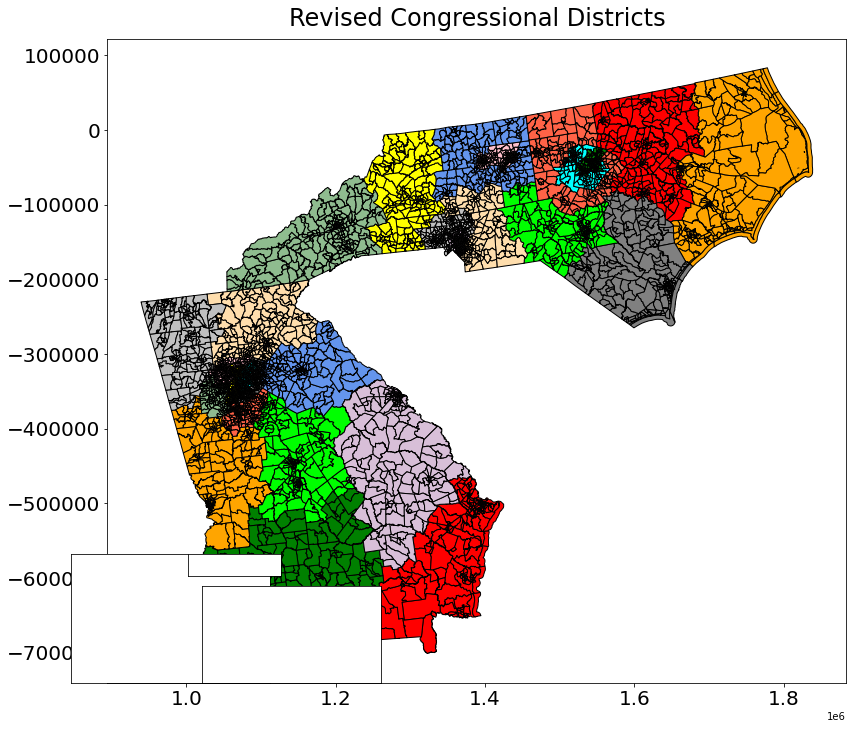

Done plotting and saving in 77 seconds!


In [19]:
s = time.time()
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "

alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = False

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    new_district_list = tract_gdf[(tract_gdf['STUSAB'] == this_state)]['new_district'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(new_district_list)+1):
        tract_gdf[
            (tract_gdf['STUSAB'] == this_state) 
            & (tract_gdf['new_district'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
    

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
#ax.legend(handles=legend_list, fontsize=10)

ax.set_title('Revised Congressional Districts', fontsize=24, y=1.01)

ax.tick_params(axis='both', labelsize=20)

# # # # # # print('saving figure...')
# # # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # # #plt.show()
# # # e = time.time()
# # # g += (e-s)
# # # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'AK')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(new_district_list)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'HI')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'HI') & (tract_gdf['new_district'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

### Check RI
# ax.set_xlim([1.9e6, 2.2e6])
# ax.set_ylim([.7e6, .9e6])

for thisax in [ak_inset_ax, aleutians_inset_ax, hi_inset_ax]: #[ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

plt.show()
# print('saving figure...')
# fig.savefig(script_dir+'new-districts-11.jpg', format='jpg', dpi=300, bbox_inches='tight')
e = time.time()
g += (e-s)
print('Done plotting and saving in {0:,.0f} seconds!'.format(e-s))


In [20]:
s = time.time()
tract_gdf['new_district'].to_csv(script_dir+'new-districts-14.csv')
e = time.time()
g += (e-s)
print('Classified and saved {0:,.0f} in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format( np.floor(g/60), g%60))

Classified and saved 5,468 in 0 minutes 0 seconds!


TOTAL TIME: 7 minutes 49 seconds!


# NORTH CAROLINA

In [21]:
# s = time.time()

# this_state = 'NC'
# examine_duplicates = True

# nDistricts = these_states_dict[this_state]['seats_new']
# state_target = these_states_dict[this_state]['target']

# print('reading from file...')
# tract_gdf.loc[:, 'new_district'] = np.nan


# df = pandas.read_csv(script_dir+'nc-so-far.csv', index_col='GEOID')
# tract_gdf.loc[df.index, 'new_district'] = df['new_district']
# tract_gdf.groupby('new_district')['POP100'].sum()


# county_mapper_df = pandas.DataFrame(data=[ 

    
# ], columns=['COUNTY_NAME', 'new_district_by_county'])
# county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

# place_mapper_df = pandas.DataFrame(data=[
    


# ], columns=['NAME', 'new_district_by_place'])

# print('Assigning districts by county...')
# for ix, thisrow in county_mapper_df.iterrows():
#     tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == thisrow['COUNTY_NAME']), 'new_district'] = thisrow['new_district_by_county']
# # #tract_gdf.loc[(tract_gdf[tract_gdf['STUSAB'] == this_state].index) & (tract_gdf['new_district'].isnull()), 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

# print('Assigning districts by place...')
# place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


# print('Accounting for known duplicate places...')
# keepers = {}
# # keepers['Fairview'] = {'GEOID': '1600000US3722500', 'description': 'overlaps 2 tracts containing 8,060 people'}


# for k,v in keepers.items():
#     print('\t{0:}: Keeping GEOID = {1:}: {2:}!'.format(k, v['GEOID'], v['description']))
#     place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == k) & (place_mapper_gdf.index != v['GEOID'])].index, axis=0)

# print('\n')
# print('checking for additional duplicate nanes...')
# duplicate_place_names = place_mapper_gdf[place_mapper_gdf['NAME'].duplicated()]['NAME'].tolist()
# for this_place in duplicate_place_names:
#     print('Examining {0:}...'.format(this_place))
    
#     for ix, thisrow in place_gdf[
#         (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (place_gdf['NAME'] == this_place)
#     ].to_crs(equal_area_crs).iterrows():
#         included_tracts = []
#         place_area = thisrow.geometry.area
#         print('\t{0:} (GEOID = {1:}), place area = {2:,.2f} km^2...'.format(thisrow['NAMELSAD'], ix, place_area / 1000000))
        
#         for jx, thatrow in county_gdf[
#             (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#             & (county_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
#         ].to_crs(equal_area_crs).iterrows():
#             if (thatrow.geometry.intersection(thisrow.geometry).area >= absolute_overlap_tol):
#                 print('\t\t...overlaps with {0:} by {1:,.2f} km^2...'.format(thatrow['NAMELSAD'], thatrow.geometry.intersection(thisrow.geometry).area / 1000000))
#                 for kx, otherrow in tract_gdf[
#                     #(tract_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#                     (tract_gdf['STUSAB'] == this_state)
#                     & (tract_gdf['COUNTY_NAME'] == thatrow['NAMELSAD'])
#                     & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
#                 ].to_crs(equal_area_crs).iterrows():
#                     tract_area = otherrow.geometry.area
#                     overlap_area = otherrow.geometry.intersection(thisrow.geometry).area
#                     pct_overlap = overlap_area / tract_area
#                     if (pct_overlap >= desired_pct_area_overlap):
#                         print('\t\t\tOverlaps {0:.1%} of census tract {1:}...'.format(pct_overlap, otherrow['census_tract']))
#                         included_tracts.append(kx)
#         print('\t{0:} (GEOID = {1:}) overlaps {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAME'], ix, len(tract_gdf[tract_gdf.index.isin(included_tracts)]), tract_gdf[tract_gdf.index.isin(included_tracts)]['POP100'].sum()))
#         print('-------------------------------------')
#         print('\n')
        
# print('\n')
# for i in range(1, nDistricts+1):
#     print('Looking for tracts related to places in District {0:.0f}...'.format(i))
#     tracts_here = []
#     this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
#     tracts_within = tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'].isnull()) 
#         & (tract_gdf.geometry.within(this_district_places_geo))
#     ].index.tolist()
#     if (len(tracts_within) > 0):
#         print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
#     tracts_here += tracts_within
    
#     intersecting_tracts = tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'].isnull()) 
#         & (tract_gdf.geometry.intersects(this_district_places_geo))
#         & ~(tract_gdf.index.isin(tracts_within))
#     ].index.tolist()
#     if (len(intersecting_tracts) > 0):
#         print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
#     cnt = 0
#     for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
#         cnt += 1
#         if (np.mod(cnt,50) == 1):            
#             print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
#         tract_area_sq_deg = thisrow.geometry.area
#         overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
#         overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
#         if (overlap_pct >= desired_pct_area_overlap):
#             tracts_here.append(ix)
#             #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

#     tract_gdf.loc[tracts_here, 'new_district'] = i

# print('Assigning districts by tract number...')


# # ##print('All the rest are district 14...')
# # ##tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 14

# print('\n')

# nDone = 0
# total_difference = 0
# total_sum = 0
# for i in [1,7]:#range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         nDone += 1
#         total_sum += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()
#         total_difference += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target
#         #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

# e = time.time()
# g += (e-s)

# print('\n')
# print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')
# print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
# print('Done!')



In [22]:
# s = time.time()

# this_state = 'NC'

# show_water = True
# label_tracts = False

# show_counties = False
# label_counties = False

# show_cbsa = False
# label_cbsa = False

# show_places = False
# label_places = False

# print_ready = False
# assign_to_district = 10

# the_label_size = 20
# the_annotation_size = 18
# the_annotation_size_big = 18
# the_line_width = .5
# the_line_width_medium = 2
# the_line_width_wide = 4
# the_legend_size = 18
# the_title_size = 28

# bounds_counties = []
# #bounds_counties = ['Craven', 'Jones', 'Pitt']
                   

                   

# #bounds_counties = ['Wake']


# if (len(bounds_counties) > 0):
#     xlimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[3]]
# else:
#     xlimits = [unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[3]]
    

# ### Western Panhandle (west)
# # xlimits = [1.04e6,1.38e6]
# # ylimits = [-250000,20000]

# ### Western Panhandle (east)
# # xlimits = [1.2e6,1.4e6]
# # ylimits = [-200000,50000]



# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

# # print(xlimits)
# # print(ylimits)
# print('xspan = {0:,.2f} km'.format(xspan / 1000))
# print('yspan = {0:,.2f} km'.format(yspan / 1000))
# print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
# print('\n')


# # fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
# fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
# ax.set_aspect('equal')


# print('plotting tracts...')
# # base layer
# legend_list = []
# for i in range(-1,these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
#         tract_gdf[(tract_gdf['new_district'] == i)].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

        
        

# tract_gdf[(tract_gdf['new_district'].isnull())].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', lw=the_line_width)



# if (show_places):
#     print('plotting places...')
#     place_gdf.to_crs(main_map_crs).plot(ax=ax, edgecolor='purple', lw=the_line_width_medium, color='none')
    

# if (show_water):
#     print('plotting water areas...')
#     water_gdf.to_crs(main_map_crs).plot(ax=ax, color='blue')#, alpha=0.5)

# if (show_counties):
#     print('plotting state and county borders...')
#     if (len(bounds_counties) > 0):   
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     else:
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width, zorder=99)

# if (label_counties):
#     print('labeling counties...')
#     if (len(bounds_counties) > 0):
#         counties_to_label = bounds_counties
#     else:
#         counties_to_label = county_gdf[county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]]['NAME'].tolist()
#     for ix, thisrow in county_gdf[
#         (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (county_gdf['NAME'].isin(counties_to_label))
# #         & ( 
# #             ((county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x) >= xlimits[0]) & (county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
# #             & ((county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y) >= xlimits[0]) & (county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y) <= xlimits[1]))
# #         )        
#     ].to_crs(main_map_crs).iterrows():
#         ax.annotate('{0:}'.format(thisrow['NAME'].replace(' ','\n')), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), color='black', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size_big)


# if (show_cbsa):
#     print('plotting CBSAs...')
#     cbsa_gdf[ (cbsa_gdf['NAME'].apply(lambda x: this_state in x[x.find(',')+2:]))].to_crs(main_map_crs).plot(ax=ax, edgecolor='white', lw=the_line_width_wide, color='none')

# if (label_cbsa):
#     for ix, thisrow in geopandas.overlay(cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x[x.find(',')+2:])].reset_index().rename(columns={'NAME': 'cbsa_name'}), state_gdf[state_gdf['STUSPS'] == this_state][['STUSPS', 'geometry']], how='intersection').set_index('GEOID').to_crs(main_map_crs).iterrows():
#         print(thisrow['cbsa_name'])
#         labelpoint = thisrow.geometry.centroid.coords[0]
#         ax.annotate('{0:}'.format(thisrow['cbsa_name'].replace(' ','\n')), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), color='red', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size_big)
        
# if (label_tracts):
#     print('\tlabeling tracts...')
#     if (print_ready):
#         print('\n')
#         print("tract_gdf.loc[[")
#     for ix, thisrow in geopandas.overlay(
#         tract_gdf[
#             (tract_gdf['new_district'].isnull())
# #            (tract_gdf['new_district'].isin([1]))
#         ].reset_index().to_crs(main_map_crs),
#         geopandas.GeoDataFrame(data=[[box(xlimits[0], ylimits[0], xlimits[1], ylimits[1])]], columns=['geometry'], crs=main_map_crs, geometry='geometry'),
#         how='intersection').set_index('GEOID').iterrows():
#             if (print_ready):
#                 print("\t'{0:}', ".format(ix))
#             else:
#                 print('\t{0:}-{1:}: {2:}'.format(thisrow['COUNTY_NAME'][0:3], thisrow['census_tract'], ix))
#             annotator = '{0:}\n({1:,.0f})'.format(thisrow['census_tract'], thisrow['POP100'])
#             centerpoint = thisrow.geometry.centroid.coords[0]
#             ax.annotate(annotator, centerpoint, color='black', ha='center', va='center', fontsize=the_annotation_size, bbox=dict(facecolor='white', edgecolor='black', pad=4))
#     if (print_ready):
#         print("], 'new_district'] = {0:.0f}".format(assign_to_district))

        
        
# if (label_places):
#     print('\tlabeling places...')
#     for ix, thisrow in geopandas.overlay(
#         place_gdf.reset_index().to_crs(main_map_crs),
#         geopandas.GeoDataFrame(data=[[box(xlimits[0], ylimits[0], xlimits[1], ylimits[1])]], columns=['geometry'], crs=main_map_crs, geometry='geometry'),
#         how='intersection').set_index('GEOID').iterrows():
#             if (thisrow['NAME'] not in []):
#                 annotator = thisrow['NAME'].replace(' ', '\n')
#                 centerpoint = thisrow.geometry.centroid.coords[0]
#                 ax.annotate(annotator, centerpoint, color='red', ha='center', va='center', fontsize=the_annotation_size, bbox=dict(facecolor='white', edgecolor='black', pad=4))

# plt.xlim(xlimits)
# plt.ylim(ylimits)

# ax.tick_params(axis='both', labelsize=20, labelbottom=True, labeltop=True, labelleft=True, labelright=True)

# # nticks = 10
# # ax.set_xticks(np.arange(xlimits[0], xlimits[1], (xlimits[1]-xlimits[0])/nticks))
# # ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))

# # ax.set_yticks(np.arange(ylimits[0], ylimits[1], (ylimits[1]-ylimits[0])/nticks))
# # ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

# # ax.xaxis.set_tick_params(labelbottom=True, labeltop=True, labelsize=the_label_size, length=10, width=4, left=True, right=True)
# # ax.yaxis.set_tick_params(labelleft=True, labelright=True, labelsize=the_label_size, length=10, width=4, top=True, bottom=True)

# #ax.legend(handles=legend_list, fontsize=the_legend_size, loc='lower left')



# if (len(list(these_states_dict.keys())) == 1):
#     plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
#         list(these_states_dict.keys())[0], 
#         these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
#     ), fontsize=the_title_size)
# else:    
#     plt.title('New Congressional Districts', fontsize=the_title_size)

# print('\n')    
# for i in [1,7]:# range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         #if (np.abs(1-(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target)) > 0.01):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

# e = time.time()
# g += (e-s)

# print('Plotted in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))

# plt.show()


In [23]:

# 	NAME	POP100
# GEOID		
# 16740	Charlotte-Concord-Gastonia, NC-SC	2249929.0
# 39580	Raleigh-Cary, NC	1413982.0
# 24660	Greensboro-High Point, NC	776566.0
# 49180	Winston-Salem, NC	675966.0
# 20500	Durham-Chapel Hill, NC	649903.0
# 22180	Fayetteville, NC	520378.0
# 11700	Asheville, NC	469015.0
# 25860	Hickory-Lenoir-Morganton, NC	365276.0
# 48900	Wilmington, NC	285905.0
# 27340	Jacksonville, NC	204576.0
# 15500	Burlington, NC	171415.0
# 24780	Greenville, NC	170243.0
# 40580	Rocky Mount, NC	143870.0
# 34820	Myrtle Beach-Conway-North Myrtle Beach, SC-NC	136693.0
# 35100	New Bern, NC	122168.0
# 24140	Goldsboro, NC	117333.0
# 31300	Lumberton, NC	116530.0
# 38240	Pinehurst-Southern Pines, NC	99727.0
# 43140	Shelby, NC	99519.0
# 48980	Wilson, NC	78784.0
# 34340	Mount Airy, NC	71359.0
# 33980	Morehead City, NC	67686.0
# 40260	Roanoke Rapids, NC	66093.0

In [24]:
######## GEORGIA ##########

# places_for_bounds = ['Alpharetta', 'Roswell']
# xlimits = [unary_union(place_gdf[place_gdf['NAME'].isin(places_for_bounds)].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(place_gdf[place_gdf['NAME'].isin(places_for_bounds)].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
# ylimits = [unary_union(place_gdf[place_gdf['NAME'].isin(places_for_bounds)].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(place_gdf[place_gdf['NAME'].isin(places_for_bounds)].to_crs(main_map_crs).geometry.tolist()).bounds[3]]

#### Between Atlanta and Lilburn
# xlimits = [1.071e6,1.083e6]
# ylimits = [-345000,-319000]

#### Suwanee
# xlimits = [1.077e6,1.09e6]
# ylimits = [-322000,-307000]

### NE of Marietta (Cobb County)
# xlimits = [1.045e6, 1.063e6]
# ylimits = [-336000,-320000]

#### S Cobb County
# xlimits = [1.036e6,1.058e6]
# ylimits = [-356000, -343000]

#### N Gwinnett County
# xlimits = [1.085e6,1.1e6]
# ylimits = [-330000,-310000]


#### S Gwinnett County
# xlimits = [1.085e6,1.1085e6]
# ylimits = [-346000,-334000]


##### S Cherokee County
# xlimits = [1.038e6,1.068e6]
# ylimits = [-322000,-302000]


#### Between Suwanee and Lawrenceville
# xlimits = [1.086e6,1.096e6]
# ylimits = [-333000,-318000]



############### NORTH CAROLINA ####################


# RALEIGH/DURHAM METRO AREA
#bounds_counties = ['Wake', 'Johnston', 'Franklin', 'Durham', 'Orange', 'Chatham', 'Granville', 'Person']

# # # CHARLOTTE METRO AREA
# bounds_counties = ['Mecklenburg', 'Cabarrus', 'York', 'Union', 'Gaston', 'Iredell', 'Rowan', 'Cleveland']
# bounds_counties += ['Lancaster', 'Lincoln', 'Stanly', 'Chester', 'Anson']
# # bounds_counties += ['Richmond', 'Montgomery', 'Catawba']

# GREENSBORO AREA
#bounds_counties = ['Guilford', 'Forsyth', 'Alamance', 'Davidson', 'Randolph', 'Rockingham', 'Surry', 'Stokes', 'Davie', 'Yadkin', 'Caswell']

# FAYETTEVILLE AREA
#bounds_counties += ['Harnett', 'Cumberland', 'Hoke']
